In [1]:
import math
import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2Model
import pandas as pd
import os
import sys
from IPython.display import HTML, display
import numpy as np
import pandas as pd
from math import ceil
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import random
import time
import string
import re


In [2]:
SUMMARY_PATH = 'MutualFundSummary'
SUMMARY_LABELS_PATH = 'MutualFundLabels.csv'

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


def get_data(PATH):
    list_dir = os.listdir(PATH)
    texts = []
    fund_names = []
    out = display(progress(0, len(list_dir)-1), display_id=True)
    for ii, filename in enumerate(list_dir) :
        with open(PATH+'/'+filename, 'r', encoding="utf8") as f :
            txt = f.read()
            try :
                txt_split = txt.split('<head_breaker>')
                summary = txt_split[1].strip()
                fund_name = txt_split[0].strip()
            except :
                summary = txt
                fund_name = ''
        texts.append(summary)
        fund_names.append(fund_name)
        out.update(progress(ii, len(list_dir)-1))
    return fund_names, texts

fund_names, summaries = get_data(SUMMARY_PATH)

df_extraction = pd.DataFrame({'fund_name' : fund_names, 'summary':summaries})
df_label = pd.read_csv(SUMMARY_LABELS_PATH)
df = df_label.merge(df_extraction, on='fund_name', how='left')
df['summary'] = df['summary'].astype(str)
df

df_low_risk = df[df['Ivestment Strategy']!= 'Long Short Funds (High Risk)']
df_high_risk = df[df['Ivestment Strategy'] == 'Long Short Funds (High Risk)']

In [3]:
df_low_risk = df_low_risk.reset_index().loc[:,'id':]
def find_string_containing_phrase(strings, phrases):
    exact_match = False
    for i, string in enumerate(strings):
        for phrase in phrases:
            if phrase == string:
                exact_match = True
            if phrase in string:
                if exact_match:
                    if i + 1 < len(strings):
                        return strings[i + 1]
                else:
                    return string
    return None

principal_investment_strategies = []
for i in range(len(df_low_risk)):
    answer = find_string_containing_phrase([x for x in df_low_risk['summary'][i].lower().split('\n') if x.strip()], ['what are the fund’s principal investment strategies?'.lower(), 'principal investment strategies', 'principal investment strategies ', 'principal investment strategy', 'principal strategies', 'What are the Fund’s main investment strategies?'.lower(), "What are the Fund's Main Investment Strategies?".lower()])
    principal_investment_strategies.append(answer)

names = [x for x in df_low_risk['fund_name']]

In [4]:
index = 0
while index < len(principal_investment_strategies):
    if principal_investment_strategies[index] is None:
        del principal_investment_strategies[index]
        del names[index]
        df_low_risk = df_low_risk.drop(index)
    else:
        index += 1
        
new_principal_investment_strategies = [x + ' ' + y for x, y in zip(names, principal_investment_strategies)]

In [5]:
df_low_risk_clean = pd.DataFrame([df_low_risk['Ivestment Strategy'].values, new_principal_investment_strategies], index = ['Ivestment Strategy', 'summary']).T
df_low_risk_clean

,Ivestment Strategy,summary
0,Balanced Fund (Low Risk),American Funds College 2018 Fund principal inv...
1,Balanced Fund (Low Risk),American Funds College 2021 Fund principal inv...
2,Balanced Fund (Low Risk),American Funds College 2024 Fund principal inv...
3,Balanced Fund (Low Risk),American Funds College 2027 Fund principal inv...
4,Balanced Fund (Low Risk),American Funds College 2030 Fund principal inv...
...,...,...
457,Fixed Income Long Only (Low Risk),American Century Diversified Corporate Bond ET...
458,Fixed Income Long Only (Low Risk),American Century Diversified Municipal Bond ET...
459,Equity Long Only (Low Risk),American Century Quality Diversified Internati...
460,Equity Long Only (Low Risk),American Century STOXX U.S. Quality Growth ETF...


In [6]:
X = df_low_risk_clean['summary']
mapping = {
    'Balanced Fund (Low Risk)': 0,
    'Fixed Income Long Only (Low Risk)': 1,
    'Equity Long Only (Low Risk)': 2,
}

y = df_low_risk_clean['Ivestment Strategy']

y = pd.Series([mapping.get(x, 0) for x in y])  

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [7]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

103

In [8]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

C:\Users\thoma\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [9]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

In [10]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

C:\Users\thoma\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [11]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [12]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [13]:
model.resize_token_embeddings(len(tokenizer))

In [14]:
for layer in model.layers:
    layer.trainable = False

In [15]:
sys.setrecursionlimit(1000)

In [16]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(3, activation='softmax')(x)

In [17]:
clf = tf.keras.Model([input, mask], output)

In [18]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
loss=tf.keras.losses.SparseCategoricalCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [19]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=3, restore_best_weights=True)

In [20]:
def map_sentiment(value):
  if value == 0:
    return 0
  if value == 1:
    return 1
  if value == 2:
    return 2

In [21]:
y_train_ = y_train.map(map_sentiment)
y_test_ = y_test.map(map_sentiment)


In [22]:
y_train_in = tf.constant(y_train_, dtype=tf.int32)
y_test_in = tf.constant(y_test_, dtype=tf.int32)

In [23]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [24]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)

C:\Users\thoma\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/30

9/9 [==============================] - 189s 18s/step - loss: 8.0062 - accuracy: 0.5217 - val_loss: 5.6893 - val_accuracy: 0.5571
Epoch 2/30
9/9 [==============================] - 157s 17s/step - loss: 6.3237 - accuracy: 0.4746 - val_loss: 3.6098 - val_accuracy: 0.5571
Epoch 3/30
9/9 [==============================] - 149s 17s/step - loss: 4.4149 - accuracy: 0.5036 - val_loss: 2.1201 - val_accuracy: 0.5571
Epoch 4/30
9/9 [==============================] - 150s 17s/step - loss: 3.1421 - accuracy: 0.4674 - val_loss: 1.2820 - val_accuracy: 0.6714
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 1.


In [25]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

4/4 [==============================] - 20s 5s/step - loss: 6.0840 - accuracy: 0.5345


[6.08402156829834, 0.5344827771186829]

In [26]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

4/4 [==============================] - 20s 5s/step


In [27]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(116,), dtype=int64, numpy=
array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2], dtype=int64)>

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [29]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        21
           1       0.00      0.00      0.00        33
           2       0.53      1.00      0.70        62

    accuracy                           0.53       116
   macro avg       0.18      0.33      0.23       116
weighted avg       0.29      0.53      0.37       116



C:\Users\thoma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\thoma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\thoma\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
confusion_df = pd.DataFrame(confusion_matrix(y_test_in, y_pred_out))
confusion_df.index = ['Actual Balanced', 'Actual Fixed Income', 'Actual Equity']
confusion_df.columns = ['Predicted Balanced', 'Predicted Fixed Income', 'Predicted Equity']
confusion_df

,Predicted Balanced,Predicted Fixed Income,Predicted Equity
Actual Balanced,0,0,21
Actual Fixed Income,0,0,33
Actual Equity,0,0,62


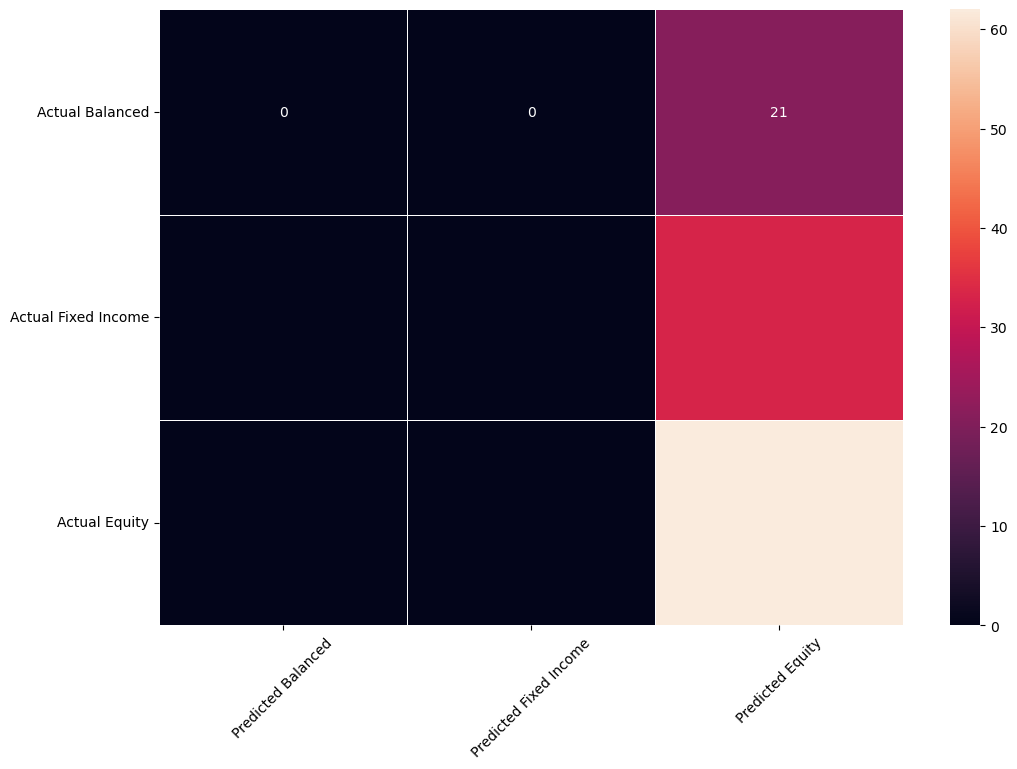

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_df, annot=True, fmt='d', linewidths=0.5) 
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()